In [3]:
#Copyright 2019, Seokjun Bu, Softcomputing LAB all rights reserved.
%matplotlib inline
import glob
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Model, load_model
from keras.utils import np_utils, multi_gpu_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Lambda, concatenate, TimeDistributed, CuDNNLSTM, BatchNormalization, LSTM
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize

Using TensorFlow backend.


In [4]:
# Handcrafted Function Definition
def plot_history(model_input, mode='loss', title='Entropy'):
    history = model_input.history
    plt.plot(history.history[mode])
    plt.plot(history.history['val_'+mode])
    plt.title(title)
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
def minmax_normalize_columnwise(input_np):
    output_np = np.zeros((input_np.shape[0], input_np.shape[1]))
    for c in range(input_np.shape[1]):
        col_min, col_max = np.min(input_np[:, c]), np.max(input_np[:, c])
        output_np[:, c] = input_np[:, c]
        output_np[:, c] -= col_min
        output_np[:, c] /= (col_max-col_min)
    return output_np
def sliding_window_np(input_np, window_size, stride):
    n_window = input_np.shape[0]-window_size+1
    X_output, Y_output = np.zeros((input_np.shape[0], window_size, input_np.shape[1])), np.zeros((input_np.shape[0], ))
    for r in range(n_window-1):
        X_output[r] = input_np[r:r+window_size]
        Y_output[r] = input_np[r+window_size, -1]
    return X_output, Y_output

In [3]:
# Column Info.
df = pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df.pkl')
columns = df.columns.values[1:]
print(columns)

['timestamp' 'hour' 'weekday' 'Temp' 'Precipitation' 'Snowfall'
 'Wind_speed' 'Wind_dir' 'Humidity' 'Air_pressure' 'NO2' 'O3' 'CO' 'SO2'
 'PM10' 'PM25' 'bike_feed' 'bike_count']


In [4]:
# Load Dataset
train, validation, test = pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_train_timeseries.pkl').values[:, 1:], pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_val_timeseries.pkl').values[:, 1:], pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_test_timeseries.pkl').values[:, 1:]
print(train.shape, validation.shape, test.shape)

(10461, 19) (4184, 19) (6277, 19)


[[ 0.000e+00  0.000e+00  2.000e-01 ...  0.000e+00  0.000e+00  7.900e+01]
 [ 1.000e+00  0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00  8.300e+01]
 [ 2.000e+00  0.000e+00 -3.000e-01 ...  0.000e+00  0.000e+00  6.100e+01]
 ...
 [ 2.200e+01  1.000e+00  1.870e+01 ...  0.000e+00  0.000e+00  3.384e+03]
 [ 2.300e+01  1.000e+00  1.850e+01 ...  0.000e+00  0.000e+00  2.500e+03]
 [ 0.000e+00  1.000e+00  1.750e+01 ...  0.000e+00  0.000e+00  2.264e+03]]


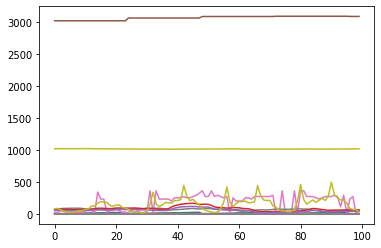

[[0.         0.         0.31468531 ... 0.         0.         0.00772354]
 [0.04347826 0.         0.31118881 ... 0.         0.         0.00811962]
 [0.08695652 0.         0.30594406 ... 0.         0.         0.00594118]
 ...
 [0.95652174 1.         0.63811189 ... 0.         0.         0.33498366]
 [1.         1.         0.63461538 ... 0.         0.         0.24745024]
 [0.         1.         0.61713287 ... 0.         0.         0.22408159]]


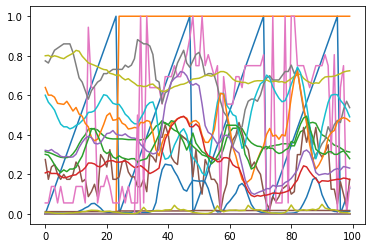

In [5]:
# Normalize Dataset
dataset = np.concatenate((train, validation, test), axis=0)
dataset_norm = minmax_normalize_columnwise(dataset)
lim = 100
print(dataset)
plt.plot(dataset[:lim])
plt.show()
print(dataset_norm)
plt.plot(dataset_norm[:lim])
plt.show()

In [6]:
# Preprocessing: Sliding-window
window_size = 10
n_window = dataset.shape[0]-window_size+1
X, Y = np.zeros((dataset.shape[0], window_size, dataset.shape[1])), np.zeros((dataset.shape[0],))
for r in range(n_window-1):
    X[r], Y[r] = dataset_norm[r:r+window_size], dataset_norm[r+window_size, -1]
print(X.shape, Y.shape)

(20922, 10, 19) (20922,)


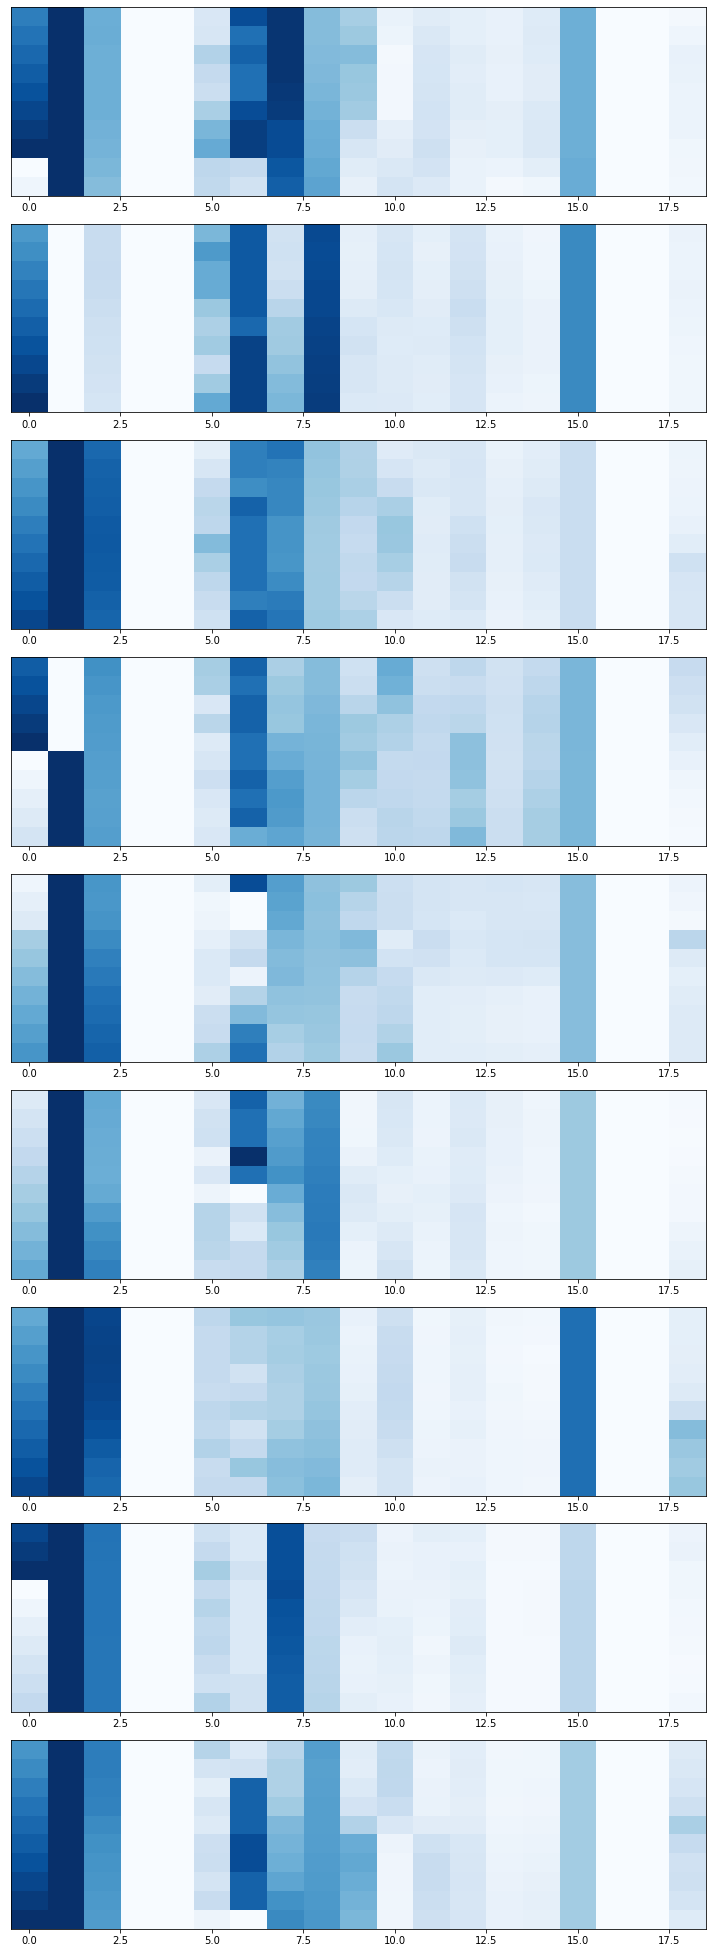

In [7]:
# Visualize Windows, Target Var.
n_vis = 10
rand_idx = np.random.randint(0, X.shape[0], n_vis)
X_sample, Y_sample = X[rand_idx], Y[rand_idx]
fig = plt.figure(figsize=(10, 30))
for nv in range(1, n_vis):
    subplot = fig.add_subplot(n_vis, 1, nv)
    subplot.imshow(X_sample[nv], cmap=plt.cm.Blues, aspect='auto')
    subplot.set_yticks([])
plt.tight_layout()
plt.show()

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(14645, 10, 19) (14645,)
(6277, 10, 19) (6277,)


In [9]:
# Build Model
c_input = Input(shape=(X.shape[1],X.shape[2]))
H = Reshape((X.shape[1], X.shape[2], 1))(c_input)
H = TimeDistributed(Convolution1D(filters=32, kernel_size=(2), padding='same', activation='tanh'))(H)
H = TimeDistributed(MaxPooling1D(2))(H)
H = TimeDistributed(Convolution1D(filters=32, kernel_size=(2), padding='same', activation='tanh'))(H)
H = TimeDistributed(MaxPooling1D(2))(H)
H = TimeDistributed(Flatten())(H)
H = Dropout(0.5)(H)
# H = CuDNNLSTM(128, return_sequences=True)(H)
H = CuDNNLSTM(128, return_sequences=False)(H)
H = Dropout(0.5)(H)
H = Dense(128, activation='tanh')(H)
H = Dense(64, activation='tanh')(H)
c_output = Dense(1, activation='tanh')(H)
model_cnn_lstm = Model(c_input, c_output)
model_cnn_lstm.summary()
model_cnn_lstm = multi_gpu_model(model_cnn_lstm, gpus=4)
model_cnn_lstm.compile(loss='mse', optimizer='adam', metrics=['binary_crossentropy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 19)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 19, 1)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 19, 32)        96        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 9, 32)         0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 9, 32)         2080      
_________________________________________________________________
time_distributed_4 (T

In [10]:
# Train Model
es = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
train_history = model_cnn_lstm.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=2000, callbacks=[es], verbose=2, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 14645 samples, validate on 6277 samples
Epoch 1/200
 - 11s - loss: 0.0261 - binary_crossentropy: 0.6530 - val_loss: 0.0166 - val_binary_crossentropy: 0.4047
Epoch 2/200
 - 0s - loss: 0.0082 - binary_crossentropy: 0.2712 - val_loss: 0.0239 - val_binary_crossentropy: 0.4483
Epoch 3/200
 - 0s - loss: 0.0062 - binary_crossentropy: 0.2859 - val_loss: 0.0151 - val_binary_crossentropy: 0.3985
Epoch 4/200
 - 0s - loss: 0.0049 - binary_crossentropy: 0.2545 - val_loss: 0.0152 - val_binary_crossentropy: 0.3983
Epoch 5/200
 - 0s - loss: 0.0044 - binary_crossentropy: 0.2670 - val_loss: 0.0136 - val_binary_crossentropy: 0.3929
Epoch 6/200
 - 0s - loss: 0.0041 - binary_crossentropy: 0.2533 - val_loss: 0.0142 - val_binary_crossentropy: 0.3947
Epoch 7/200
 - 0s - loss: 0.0039 - binary_crossentropy: 0.2601 - val_loss: 0.0129 - val_binary_crossentropy: 0.3903
Epoch 8/200
 - 0s - loss: 0.0038 - binary_crossentropy: 0.2566 - val_loss: 0.0131 - val_bi

Epoch 69/200
 - 0s - loss: 0.0015 - binary_crossentropy: 0.2384 - val_loss: 0.0045 - val_binary_crossentropy: 0.3635
Epoch 70/200
 - 0s - loss: 0.0015 - binary_crossentropy: 0.2383 - val_loss: 0.0040 - val_binary_crossentropy: 0.3617
Epoch 71/200
 - 0s - loss: 0.0015 - binary_crossentropy: 0.2383 - val_loss: 0.0046 - val_binary_crossentropy: 0.3634
Epoch 72/200
 - 0s - loss: 0.0015 - binary_crossentropy: 0.2380 - val_loss: 0.0038 - val_binary_crossentropy: 0.3611
Epoch 73/200
 - 0s - loss: 0.0015 - binary_crossentropy: 0.2383 - val_loss: 0.0052 - val_binary_crossentropy: 0.3657
Epoch 74/200
 - 0s - loss: 0.0015 - binary_crossentropy: 0.2395 - val_loss: 0.0043 - val_binary_crossentropy: 0.3622
Epoch 75/200
 - 0s - loss: 0.0015 - binary_crossentropy: 0.2397 - val_loss: 0.0040 - val_binary_crossentropy: 0.3614
Epoch 76/200
 - 0s - loss: 0.0014 - binary_crossentropy: 0.2378 - val_loss: 0.0040 - val_binary_crossentropy: 0.3616
Epoch 77/200
 - 0s - loss: 0.0014 - binary_crossentropy: 0.2372 

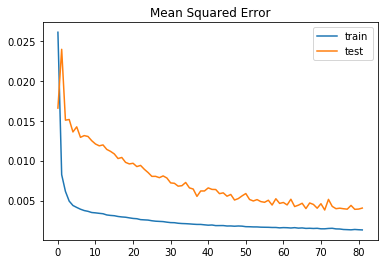

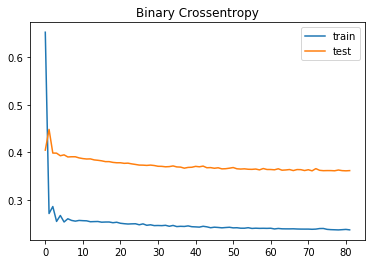

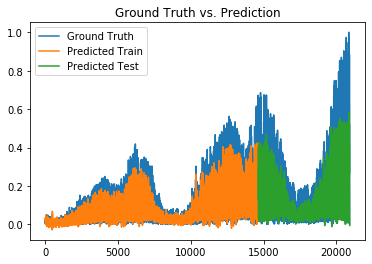

In [11]:
# Validation
# Curve
plot_history(model_cnn_lstm, mode='loss', title='Mean Squared Error')
plot_history(model_cnn_lstm, mode='binary_crossentropy', title='Binary Crossentropy')
# Prediction
Y_train_hat = model_cnn_lstm.predict(X_train)
Y_test_hat = model_cnn_lstm.predict(X_test)
plt.plot(range(Y_train_hat.shape[0]+Y_test_hat.shape[0]), np.concatenate((Y_train, Y_test)), label='Ground Truth') # Ground Truth
plt.plot(range(Y_train_hat.shape[0]), Y_train_hat, label='Predicted Train') # Train Period Prediction
plt.plot(range(Y_train_hat.shape[0], Y_train_hat.shape[0]+Y_test_hat.shape[0]), Y_test_hat, label='Predicted Test') # Test Period Prediction
plt.legend(loc='upper left')
plt.title('Ground Truth vs. Prediction')
plt.show()

In [12]:
# Build Deeper Model
c_input = Input(shape=(X.shape[1],X.shape[2]))
H = Reshape((X.shape[1], X.shape[2], 1))(c_input)
H = TimeDistributed(Convolution1D(filters=32, kernel_size=(2), padding='same', activation='tanh'))(H)
H = TimeDistributed(MaxPooling1D(2))(H)
H = TimeDistributed(Convolution1D(filters=32, kernel_size=(2), padding='same', activation='tanh'))(H)
H = TimeDistributed(MaxPooling1D(2))(H)
H = TimeDistributed(Flatten())(H)
H = Dropout(0.75)(H)
H = CuDNNLSTM(128, return_sequences=True)(H)
H = CuDNNLSTM(128, return_sequences=False)(H)
H = Dropout(0.75)(H)
H = Dense(128, activation='tanh')(H)
H = Dense(64, activation='tanh')(H)
c_output = Dense(1, activation='tanh')(H)
model_cnn_lstm = Model(c_input, c_output)
model_cnn_lstm.summary()
model_cnn_lstm = multi_gpu_model(model_cnn_lstm, gpus=4)
model_cnn_lstm.compile(loss='mse', optimizer='adam', metrics=['binary_crossentropy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10, 19)            0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 10, 19, 1)         0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 19, 32)        96        
_________________________________________________________________
time_distributed_7 (TimeDist (None, 10, 9, 32)         0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 10, 9, 32)         2080      
_________________________________________________________________
time_distributed_9 (TimeDist (None, 10, 4, 32)         0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 10, 128)           0         
__________

In [13]:
# Train Model
es = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
train_history = model_cnn_lstm.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=2000, batch_size=2000, callbacks=[es], verbose=2, shuffle=True)

Train on 14645 samples, validate on 6277 samples
Epoch 1/2000
 - 2s - loss: 0.0199 - binary_crossentropy: 0.5249 - val_loss: 0.0240 - val_binary_crossentropy: 0.4462
Epoch 2/2000
 - 0s - loss: 0.0076 - binary_crossentropy: 0.2741 - val_loss: 0.0225 - val_binary_crossentropy: 0.4354
Epoch 3/2000
 - 0s - loss: 0.0062 - binary_crossentropy: 0.2650 - val_loss: 0.0170 - val_binary_crossentropy: 0.4060
Epoch 4/2000
 - 0s - loss: 0.0053 - binary_crossentropy: 0.2559 - val_loss: 0.0173 - val_binary_crossentropy: 0.4073
Epoch 5/2000
 - 0s - loss: 0.0048 - binary_crossentropy: 0.2598 - val_loss: 0.0143 - val_binary_crossentropy: 0.3957
Epoch 6/2000
 - 0s - loss: 0.0046 - binary_crossentropy: 0.2579 - val_loss: 0.0149 - val_binary_crossentropy: 0.3973
Epoch 7/2000
 - 0s - loss: 0.0044 - binary_crossentropy: 0.2527 - val_loss: 0.0148 - val_binary_crossentropy: 0.3969
Epoch 8/2000
 - 0s - loss: 0.0042 - binary_crossentropy: 0.2546 - val_loss: 0.0141 - val_binary_crossentropy: 0.3947
Epoch 9/2000
 -

 - 0s - loss: 0.0017 - binary_crossentropy: 0.2390 - val_loss: 0.0043 - val_binary_crossentropy: 0.3626
Epoch 71/2000
 - 0s - loss: 0.0016 - binary_crossentropy: 0.2378 - val_loss: 0.0044 - val_binary_crossentropy: 0.3630
Epoch 72/2000
 - 0s - loss: 0.0016 - binary_crossentropy: 0.2384 - val_loss: 0.0046 - val_binary_crossentropy: 0.3633
Epoch 73/2000
 - 0s - loss: 0.0016 - binary_crossentropy: 0.2376 - val_loss: 0.0044 - val_binary_crossentropy: 0.3630
Epoch 74/2000
 - 0s - loss: 0.0015 - binary_crossentropy: 0.2370 - val_loss: 0.0053 - val_binary_crossentropy: 0.3664
Epoch 75/2000
 - 0s - loss: 0.0016 - binary_crossentropy: 0.2379 - val_loss: 0.0043 - val_binary_crossentropy: 0.3623
Epoch 76/2000
 - 0s - loss: 0.0015 - binary_crossentropy: 0.2373 - val_loss: 0.0041 - val_binary_crossentropy: 0.3617
Epoch 77/2000
 - 0s - loss: 0.0016 - binary_crossentropy: 0.2376 - val_loss: 0.0052 - val_binary_crossentropy: 0.3655
Epoch 78/2000
 - 0s - loss: 0.0016 - binary_crossentropy: 0.2371 - val

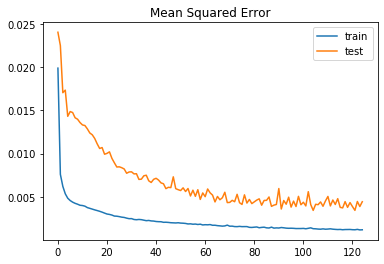

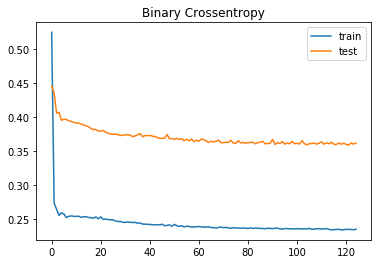

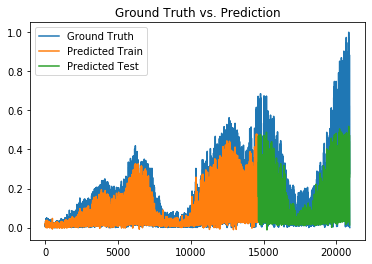

In [14]:
# Validation
# Curve
plot_history(model_cnn_lstm, mode='loss', title='Mean Squared Error')
plot_history(model_cnn_lstm, mode='binary_crossentropy', title='Binary Crossentropy')
# Prediction
Y_train_hat = model_cnn_lstm.predict(X_train)
Y_test_hat = model_cnn_lstm.predict(X_test)
plt.plot(range(Y_train_hat.shape[0]+Y_test_hat.shape[0]), np.concatenate((Y_train, Y_test)), label='Ground Truth') # Ground Truth
plt.plot(range(Y_train_hat.shape[0]), Y_train_hat, label='Predicted Train') # Train Period Prediction
plt.plot(range(Y_train_hat.shape[0], Y_train_hat.shape[0]+Y_test_hat.shape[0]), Y_test_hat, label='Predicted Test') # Test Period Prediction
plt.legend(loc='upper left')
plt.title('Ground Truth vs. Prediction')
plt.show()